# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [3]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')
%matplotlib inline

In [4]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Prepare backtesting data

In [5]:
MODEL_STORE = 'data/models.h5' 
DATA_STORE = 'data/data.h5'
BACKTRADER_STORE = 'data/backtrader.h5';

In [6]:
def get_backtest_data(predictions='lasso_regression/predictions'):
    with pd.HDFStore(DATA_STORE) as store:
        prices = (store['stocks/historical_prices']
                  .swaplevel(axis=0))

    with pd.HDFStore(MODEL_STORE) as store:
        predictions = store[predictions]

    best_alpha = predictions.groupby('alpha').apply(lambda x: spearmanr(x.actuals, x.predicted)[0]).idxmax()
    predictions = predictions[predictions.alpha == best_alpha]
    predictions.index.names = ['ticker', 'date']
    tickers = predictions.index.get_level_values('ticker').unique()
    start = predictions.index.get_level_values('date').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('date').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    idx = pd.IndexSlice
    prices = prices.sort_index().loc[idx[tickers, start:stop], :]
    predictions = predictions.loc[predictions.alpha == best_alpha, ['predicted']]
    return predictions.join(prices, how='right')


data = get_backtest_data()
data.head()

predicted  Unnamed: 0       open       high        low      close   adjClose     volume  unadjustedVolume   change  changePercent      vwap            label  changeOverTime
ticker date                                                                                                                                                                                    
AAPL   2018-12-12  -0.003328       56352  42.599998  42.979999  42.255001  42.275002  40.802803  142510800         142510800 -1.79720         -4.219  42.01260  December 12, 18        -0.04219
       2018-12-13  -0.002821       56351  42.622501  43.142502  42.387501  42.737499  41.249203  127594400         127594400 -1.37330         -3.222  42.25974  December 13, 18        -0.03222
       2018-12-14  -0.002101       56350  42.250000  42.270001  41.320000  41.369999  39.929318  162814800         162814800 -2.32068         -5.493  41.17311  December 14, 18        -0.05493
       2018-12-17  -0.002135       56349  41.362499  42.087502  40.682499  40.985001  39.557735  177151600         177151600 -1.80476         -4.363  40.77591  December 17, 18        -0.04363
       2018-12-18  -0.001812       56348  41.345001  41.882500  41.097500  41.517502  40.071682  135366000         135366000 -1.27332         -3.080  41.01723  December 18, 18        -0.03080

## Backtrader Setup

### Custom Commission Scheme

In [7]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

### DataFrame Loader

In [8]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [9]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Strategy

Includes an option to only trade on certain weekdays in lines 39/40.

In [10]:
class MLStrategy(bt.Strategy):
    params = (('n_positions', 20),
              ('min_positions', 15),
              ('verbose', True),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        print([dt.isoformat()] + txt.split(','))
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log(f'{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log(f'{ticker},LONG ORDER CREATED')

### Create and Configure Cerebro Instance

In [11]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000
# comminfo = FixedCommisionScheme()
# cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

### Add input data

In [12]:
idx = pd.IndexSlice
data = data.sort_index()
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'date'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 213213 entries, ('AAL', Timestamp('2018-12-12 00:00:00')) to ('ZTS', Timestamp('2022-12-01 00:00:00'))
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   predicted         98984 non-null   float64
 1   Unnamed: 0        213213 non-null  int64  
 2   open              213213 non-null  float64
 3   high              213213 non-null  float64
 4   low               213213 non-null  float64
 5   close             213213 non-null  float64
 6   adjClose          213213 non-null  float64
 7   volume            213213 non-null  int64  
 8   unadjustedVolume  213213 non-null  int64  
 9   change            213213 non-null  float64
 10  changePercent     213213 non-null  float64
 11  vwap              213213 non-null  float64
 12  label             213213 non-null  object 
 13  changeOverTime    213213 non-null  float64
dtypes: float64(10), int64(3), object(1)
memor

### Run Strategy Backtest

In [14]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=20, min_positions=15, 
                    verbose=True, log_file='data/bt_log.csv')
start = time()
starting_value = cerebro.broker.getvalue()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start
print(f'Starting Portfolio Value: {starting_value:,.2f}')
print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

['2019-01-02T00:00:00', 'GE', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'FANG', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'NKE', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'LLY', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'DD', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'ABBV', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'CRM', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'AMAT', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'TGT', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'LRCX', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'GS', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'WMT', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'BMY', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'BAC', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'BA', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'GOOG', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'TXN', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'HD', 'SHORT ORDER CREATED']
['2019-01-02T00:00:00', 'BRK

Disabled because large number of datafeeds all plot separately.

### Get `pyfolio` inputs

In [15]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()



In [16]:
returns.to_hdf(BACKTRADER_STORE, 'returns')
positions.to_hdf(BACKTRADER_STORE, 'positions')
transactions.to_hdf(BACKTRADER_STORE, 'transactions')
gross_lev.to_hdf(BACKTRADER_STORE, 'gross_lev')

In [17]:
pyfolio = results[0].analyzers.getbyname('pyfolio')

In [18]:
returns = pd.read_hdf(BACKTRADER_STORE, 'returns')
positions = pd.read_hdf(BACKTRADER_STORE, 'positions')
transactions = pd.read_hdf(BACKTRADER_STORE, 'transactions')
gross_lev = pd.read_hdf(BACKTRADER_STORE, 'gross_lev')

In [19]:
benchmark = web.DataReader('SP500', 'fred', '2018', '2023').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [20]:
benchmark

DATE
2018-01-01 00:00:00+00:00         NaN
2018-01-02 00:00:00+00:00         NaN
2018-01-03 00:00:00+00:00    0.006399
2018-01-04 00:00:00+00:00    0.004029
2018-01-05 00:00:00+00:00    0.007034
                               ...   
2022-12-26 00:00:00+00:00    0.000000
2022-12-27 00:00:00+00:00   -0.004050
2022-12-28 00:00:00+00:00   -0.012021
2022-12-29 00:00:00+00:00    0.017461
2022-12-30 00:00:00+00:00   -0.002541
Name: SP500, Length: 1305, dtype: float64

In [21]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

In [22]:
returns

index
2018-12-12 00:00:00+00:00    0.0
2018-12-13 00:00:00+00:00    0.0
2018-12-14 00:00:00+00:00    0.0
2018-12-17 00:00:00+00:00    0.0
2018-12-18 00:00:00+00:00    0.0
                            ... 
2022-11-25 00:00:00+00:00    0.0
2022-11-28 00:00:00+00:00    0.0
2022-11-29 00:00:00+00:00    0.0
2022-11-30 00:00:00+00:00    0.0
2022-12-01 00:00:00+00:00    0.0
Name: return, Length: 1001, dtype: float64

In [23]:
benchmark

DATE
2018-01-01 00:00:00+00:00         NaN
2018-01-02 00:00:00+00:00         NaN
2018-01-03 00:00:00+00:00    0.006399
2018-01-04 00:00:00+00:00    0.004029
2018-01-05 00:00:00+00:00    0.007034
                               ...   
2022-12-26 00:00:00+00:00    0.000000
2022-12-27 00:00:00+00:00   -0.004050
2022-12-28 00:00:00+00:00   -0.012021
2022-12-29 00:00:00+00:00    0.017461
2022-12-30 00:00:00+00:00   -0.002541
Name: SP500, Length: 1305, dtype: float64

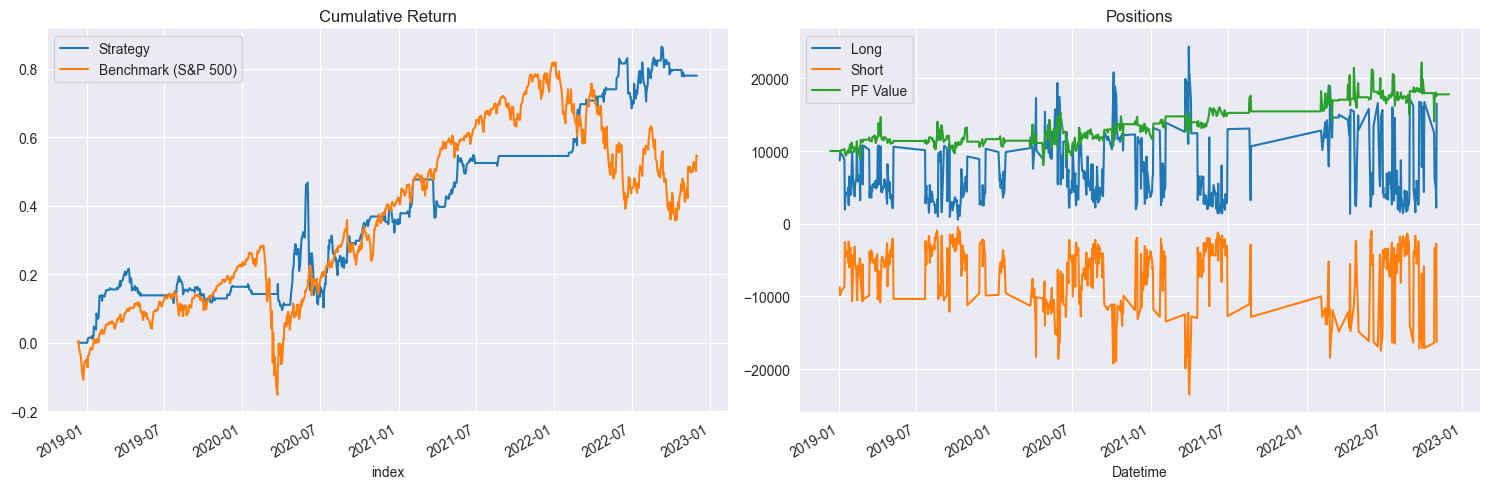

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

Start date,2018-12-12
End date,2022-12-01
Total months,47
,Backtest
Annual return,15.6%
Cumulative returns,78.0%
Annual volatility,16.1%
Sharpe ratio,0.98
Calmar ratio,0.63
Stability,0.93
Max drawdown,-24.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.86,2020-06-02,2020-07-09,2021-02-04,178
1,9.93,2019-04-09,2020-04-03,2020-04-29,277
2,8.02,2022-06-21,2022-07-01,2022-08-22,45
3,7.52,2021-03-19,2021-03-26,2021-05-18,43
4,6.05,2020-05-04,2020-05-13,2020-05-18,11


Stress Events,mean,min,max
New Normal,0.06%,-6.75%,6.93%


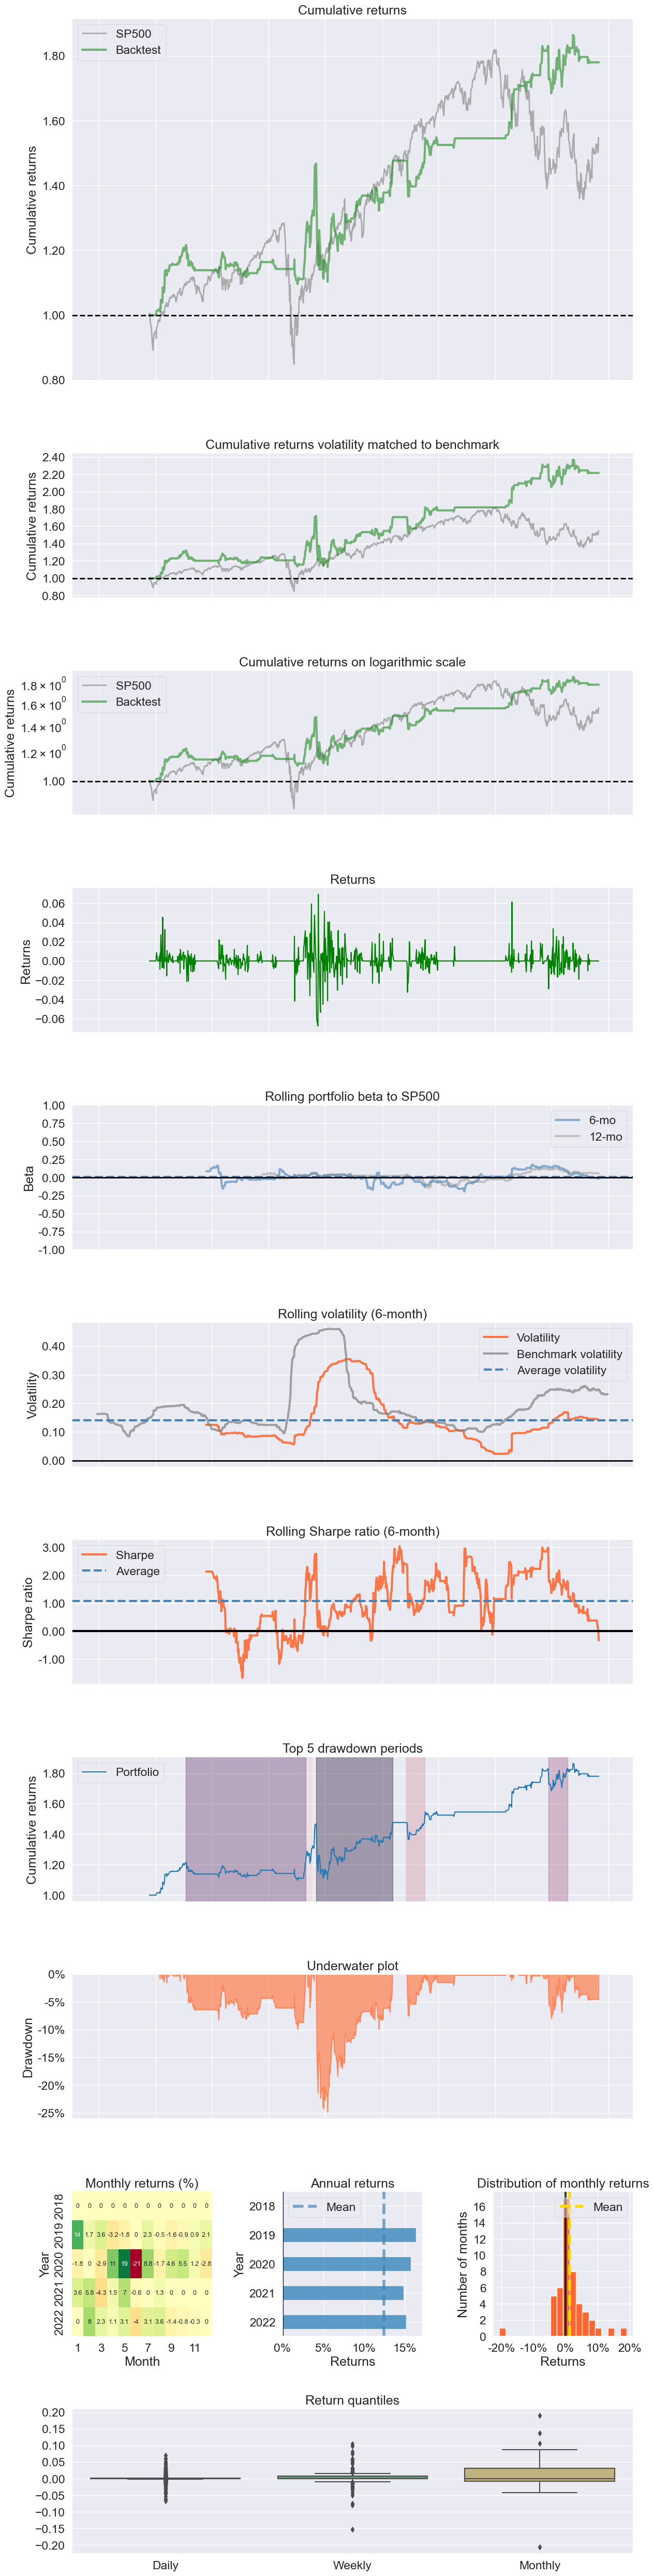

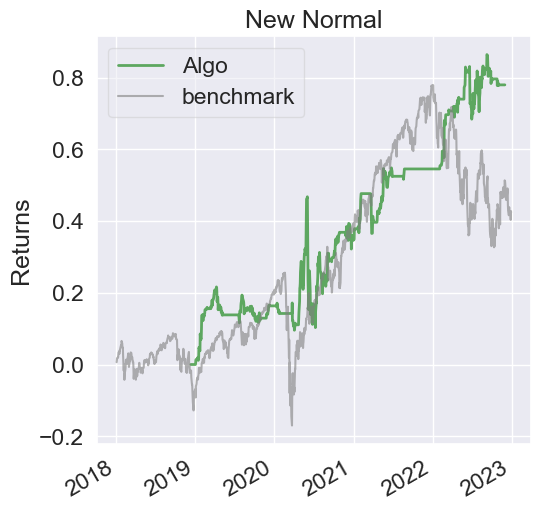

In [25]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          benchmark_rets=benchmark.dropna())

In [26]:
returns.tail()

index
2022-11-25 00:00:00+00:00    0.0
2022-11-28 00:00:00+00:00    0.0
2022-11-29 00:00:00+00:00    0.0
2022-11-30 00:00:00+00:00    0.0
2022-12-01 00:00:00+00:00    0.0
Name: return, dtype: float64

In [27]:
gross_lev

index
2018-12-12 00:00:00+00:00    0.0
2018-12-13 00:00:00+00:00    0.0
2018-12-14 00:00:00+00:00    0.0
2018-12-17 00:00:00+00:00    0.0
2018-12-18 00:00:00+00:00    0.0
                            ... 
2022-11-25 00:00:00+00:00    0.0
2022-11-28 00:00:00+00:00    0.0
2022-11-29 00:00:00+00:00    0.0
2022-11-30 00:00:00+00:00    0.0
2022-12-01 00:00:00+00:00    0.0
Name: gross_lev, Length: 1001, dtype: float64

In [28]:
positions

,ZTS,cash
Datetime,,
2018-12-12 00:00:00+00:00,0.0,10000.000000
2018-12-13 00:00:00+00:00,0.0,10000.000000
2018-12-14 00:00:00+00:00,0.0,10000.000000
2018-12-17 00:00:00+00:00,0.0,10000.000000
2018-12-18 00:00:00+00:00,0.0,10000.000000
...,...,...
2022-11-25 00:00:00+00:00,0.0,17797.614383
2022-11-28 00:00:00+00:00,0.0,17797.614383
2022-11-29 00:00:00+00:00,0.0,17797.614383


In [29]:
benchmark

DATE
2018-01-01 00:00:00+00:00         NaN
2018-01-02 00:00:00+00:00         NaN
2018-01-03 00:00:00+00:00    0.006399
2018-01-04 00:00:00+00:00    0.004029
2018-01-05 00:00:00+00:00    0.007034
                               ...   
2022-12-26 00:00:00+00:00    0.000000
2022-12-27 00:00:00+00:00   -0.004050
2022-12-28 00:00:00+00:00   -0.012021
2022-12-29 00:00:00+00:00    0.017461
2022-12-30 00:00:00+00:00   -0.002541
Name: SP500, Length: 1305, dtype: float64

In [30]:
transactions.tail()

,amount,price,sid,symbol,value
date,,,,,
2022-11-02 00:00:00+00:00,-4,196.350006,196,UNP,785.400024
2022-11-02 00:00:00+00:00,-5,166.149994,197,UPS,830.749970
2022-11-02 00:00:00+00:00,19,46.880001,207,WFC,-890.720021
2022-11-02 00:00:00+00:00,6,141.160004,208,WMT,-846.960022
2022-11-02 00:00:00+00:00,-8,111.580002,211,XOM,892.640014
